# **Material Search**

> This notebook is to be used for the Data Science MSc Thesis of Gustavo Fonseca. Data is provided by Mota Engil and should support the Supply Chain in the Mota-Engil group.

**Objective**: cluster the materials by similarity to each other.

**Method**: I start by (1) exploring the data and showing why I did not use a lot of other information, and why I ended up using only the levenshtein distance betweeen words and sentences. (2) I build up the code for the levenshtein distance, apply it to build the distances matrix and (3) apply it to DBScan to get clusters.

In [1]:
# imports
# get data from Azure
import json
import pyodbc
import textwrap

# imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import nltk

import locale
from collections import defaultdict, Counter
import unicodedata as unic
import re

# Text Processing
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


locale.getpreferredencoding()

'UTF-8'

# Connect and Extract the data from Azure SQL Database

Connect to SQL Database to Extract the data. I use an SQL Query to get more information from the materials.

In [3]:
GET_DATA = False

if GET_DATA:
    
    with open('variables/variables.json') as f:
          vars_ = json.load(f)


    # Specify the Driver.
    driver = '{ODBC Driver 17 for SQL Server}'

    # Specify Server Name and Database Name.
    server_name = vars_['server_name']
    database = vars_['database']

    # Create our Server URL.
    server = f'{server_name}.database.windows.net,1433'

    # Define Username & Password # TODO
    login = vars_['login']
    password = vars_['password']

    # Create the full connection string.
    connection_string = textwrap.dedent(f'''
        Driver={driver};
        Server={server};
        Database={database};
        Uid={login};
        Pwd={password};
        Encrypt=yes;
        TrustServerCertificate=no;
        Connection Timeout=30;
    ''')

    # Create a new PYODBC Connection Object
    cnxn: pyodbc.Connection = pyodbc.connect(connection_string)

    # Create a new Cursor Object from the connection
    crsr: pyodbc.Cursor = cnxn.cursor()

    # Define a select Query.
    select_sql = """SELECT zmm001.Material, 
    CAST(zmm001.MaterialDescription AS VARCHAR(MAX)) AS MaterialDescription, 
    zmm001.MaterialGroup, 
    CAST(zmm001.MaterialGroupDescription AS VARCHAR(MAX)) AS MaterialGroupDescription, 
    zmm001.Unit, 
    zmm001.MaterialType, 
    zmm001.Created, 
    zmm001.LastChange, 
    ISNULL(AVG(mb51view.ValuePerUnit), '0') as AveragePrice,
    ISNULL(STDEV(mb51view.ValuePerUnit), '0') as STDPrice,
    ISNULL(COUNT(mb51view.ValuePerUnit), '0') as CountMovements
    FROM [PPP].[ZMM001] as zmm001
    LEFT JOIN (
    SELECT Material, MovementValueEuro / Quantity AS ValuePerUnit
    FROM [PPP].[MB51view]
    WHERE Quantity > 0
    ) as mb51view
    ON mb51view.Material=zmm001.Material
    GROUP BY
    zmm001.Material,
    CAST(zmm001.MaterialDescription AS VARCHAR(MAX)),
    zmm001.MaterialGroup,
    CAST(zmm001.MaterialGroupDescription AS VARCHAR(MAX)),
    zmm001.Unit,
    zmm001.MaterialType,
    zmm001.Created,
    zmm001.LastChange
    """

    # Read to Pandas
    data = pd.read_sql(select_sql, cnxn)

    # Close the connection once we are done
    cnxn.close()
    
    data['Created'] = pd.to_datetime(data['Created'])
    data['LastChange'] = pd.to_datetime(data['LastChange'])
    data = data.replace(['', 'null', '#N/A'], [np.nan, np.nan, np.nan])
    
    data.to_csv('data/material_data.csv', index=False)

else:
    
    data = pd.read_csv(
        'data/material_data.csv', 
        dtype={
            'Material': str, 
            'MaterialDescription': str, 
            'MaterialGroup': str, 
            'MaterialGroupDescription': str, 
            'Unit': str, 
            'MaterialType': str, 
            'Created': str, 
            'LastChange': str,
            'AveragePrice': float,
            'STDPrice': float,
            'CountMovements': int
        },
        parse_dates=['Created', 'LastChange'])

# Data Exploration

This section is focused in analysing the data and seeing their worth for the purpose of this project. We want data that would allow to calculate distances between all materials

In [4]:
data_p = data.copy()
data_p.head()

,Material,MaterialDescription,MaterialGroup,MaterialGroupDescription,Unit,MaterialType,Created,LastChange,AveragePrice,STDPrice,CountMovements
0,100001,G OFFICE FURNITURE,259807,Several Services,UN,ZSUB,2019-12-26,2021-05-02,0.0,0.0,0
1,100008,G BRICK MASONRIES,200101,Brick Masonries,UN,ZSUB,2019-12-08,2021-03-19,0.0,0.0,7
2,100009,G CONCRETE BLOCKS MASONRY,200102,Concrete Bolcks Masonry,UN,ZSUB,2019-12-08,2021-01-14,0.0,0.0,92
3,100012,G REINFORCING STEEL,200301,Reinforcing Steel,UN,ZSUB,2019-12-10,2021-05-02,0.0,0.0,21
4,100014,G EXTERIOR ARRANGEMENTS,200401,Exterior Arrangements,UN,ZSUB,2019-12-08,2021-05-02,0.0,0.0,70


Get only materials (ZMAT) and tools & equipment (ZPEC) from the dataset.

In [5]:
# Keep only ZMAT & ZPEC
data_p = data_p[(data_p.MaterialType=='ZMAT') | (data_p.MaterialType=='ZPEC')].copy()

Fix some found description problems:
* Spacing
* NaNs
* O RING to ORING

In [6]:
# Change 2 spacings to 1 spacing
data_p = data_p.replace('\s{2,}', ' ', regex=True)

# NaN to None
data_p = data_p.replace({np.nan: None})

# O RING to ORING
data_p = data_p.replace('[^\w]O RING', 'ORING', regex=True)

Get some general statistics for each of the columns

In [7]:
# Get the cardinality and number of null values for each column

# Material is primary key therefore it is never null

cols_to_check = [
    'MaterialDescription',
    'MaterialGroup',
    'MaterialGroupDescription',
    'Unit',
    'MaterialType',
    'Created',
    'LastChange',
]

cols_numbers = [
    'AveragePrice',
    'STDPrice',
    'CountMovements'
]

stats_data = np.empty([len(cols_to_check) +  len(cols_numbers), 6], dtype=int)
types = []
nr_words = []

for i, col in enumerate(cols_to_check):
    stats_data[i, :] = [len(data_p[col].unique()), (data_p[col].isnull()).sum(), (data_p[col]=='').sum(), 0, 0, 0]
    types.append(data[col].dtype)
    
for i, col in enumerate(cols_numbers):
    stats_data[i + 7, :] = [len(data_p[col].unique()), (data_p[col].isnull()).sum(), (data_p[col]=='').sum(), (data_p[col]==0).sum(), int(data_p[col].min()), int(data_p[col].max())]
    types.append(data[col].dtype)
    
stats_data = pd.DataFrame(stats_data, columns=['Cardinality', 'Nulls', 'Blank', 'Zeros', 'Min', 'Max'], index=cols_to_check+cols_numbers)
stats_data['Dtype'] = types


for col in ['Created', 'LastChange']:
    stats_data.loc[col, 'Min'] = data_p[col].dt.date.min()
    stats_data.loc[col, 'Max'] = data_p[col].dt.date.max()

stats_data.head(10)

,Cardinality,Nulls,Blank,Zeros,Min,Max,Dtype
MaterialDescription,136609,1135,0,0,0,0,object
MaterialGroup,333,0,0,0,0,0,object
MaterialGroupDescription,326,100,0,0,0,0,object
Unit,34,0,0,0,0,0,object
MaterialType,2,0,0,0,0,0,object
Created,415,0,0,0,2018-12-17,2021-04-26,datetime64[ns]
LastChange,315,0,0,0,2019-04-12,2021-12-03,datetime64[ns]
AveragePrice,109985,0,0,110678,0,383602,float64
STDPrice,53207,0,0,175018,0,219277,float64
CountMovements,199,0,0,85153,0,4510,int64


AveragePrice and STDPrice have both a lot of zeros, which are indicative of no price information. These 0s represent more than 50% of the data. So I will proceed with eliminating these columns.

In [8]:
data_p.drop(columns=['AveragePrice', 'STDPrice'], inplace=True) # delete columns

The dates of creation and change can be indicative of similar seasonal needs but with so many diverse projects happening at the same time, it is also risky trying to infer anything with it.

In [9]:
data_p.drop(columns=['Created', 'LastChange'], inplace=True)

A very big percentage of materials have no registered movement, therefore it should also be hard to cluter using this information. In any case this data can be used to sort the results from the material search.

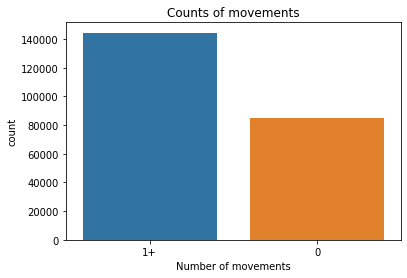

In [10]:
data_p['movements_category'] = data_p['CountMovements'].apply(lambda x: '0' if x < 1 else '1+')
ax = sns.countplot(data=data_p, x='movements_category')
ax.set_xlabel('Number of movements')
ax.set_title('Counts of movements');

In [11]:
data_p.drop(columns=['CountMovements', 'movements_category'], inplace=True)

Material Group and Type information are both already clustered groups of data, and we can use them to calculate evaluation metrics with pseudo ground truth. They won't be reliable since they have mixed types of groups: some are grouped by the brand (e.g. Volvo and Toyota) and others are grouped by their utility.

MaterialGroup is the MaterialGroupDescription ID and Material Type we have only two groups so we will eliminate both of these.

In [12]:
data_p.drop(columns=['MaterialGroup', 'MaterialType'], inplace=True)

In [13]:
# We will save the MaterialGroupDescription for evaluating the results after
ground_truth = data_p['MaterialGroupDescription']
data_p.drop(columns=['MaterialGroupDescription'], inplace=True)

In [14]:
# End result
data_p.head()

,Material,MaterialDescription,Unit
39,100092,G PROSPECÇÃO GEOFÍSICA,UN
4741,40000000,G LUBRICANTS,UN
4742,40000002,G TARPAULIN,UN
4743,40000003,INK CARTRIDGE HP CB436A-36A,UN
4744,40000005,"SPRING MATTRESS 1,90X0,90",UN


**Outcome**
We will calculate distances between the material descriptions and use a penalty of +1 in case the unit of the material is also not the same

# **Calculating Distances**

Levenshtein Distance + Unit Penalty

In [15]:
# first we turn the description into a cleaned version

# function to extract type of word
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# multiple functions to clean the t
def clean_text(text):
    # clean any unicode formatting left
    text = unic.normalize("NFKD", text)
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # replace the rest of the punctuation by space
    text = ' '.join(text)
    text = [w for w in re.split('\.|\-|\s|\,|\(|\_|\d', text)]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words | Not really needed
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0],  get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
data_p["description_clean"] = data_p["MaterialDescription"].apply(lambda x: clean_text(x) if x is not None else "")
data_p.head()

,Material,MaterialDescription,Unit,description_clean
39,100092,G PROSPECÇÃO GEOFÍSICA,UN,prospecção geofísica
4741,40000000,G LUBRICANTS,UN,lubricant
4742,40000002,G TARPAULIN,UN,tarpaulin
4743,40000003,INK CARTRIDGE HP CB436A-36A,UN,ink cartridge
4744,40000005,"SPRING MATTRESS 1,90X0,90",UN,spring mattress


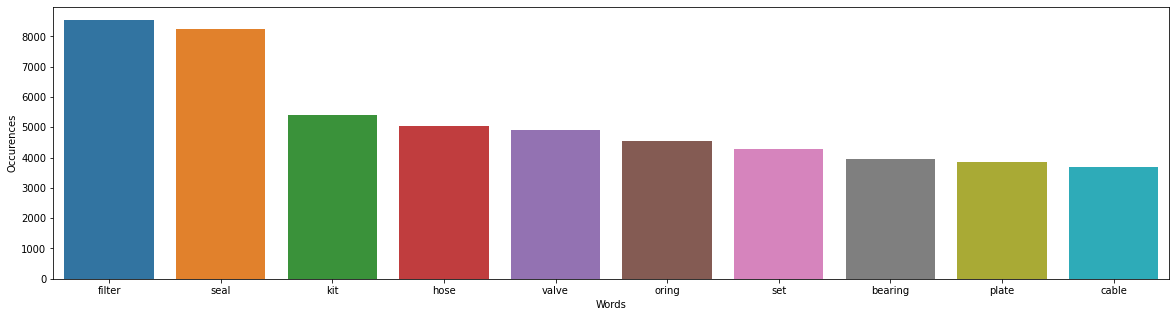

In [16]:
# Top 10 words after cleaning
top10words_df = pd.DataFrame(Counter(" ".join(data_p["description_clean"]).split()).most_common(10), columns=['Words', 'Occurences'])
plt.figure(figsize=(20,5))
ax = sns.barplot(data=top10words_df, x='Words', y='Occurences')

In [179]:
# missing description will be set to undefined
data_p.loc[data_p.description_clean.str.contains('^$'), 'description_clean'] = 'undefined'

Now that we have clean descriptions, we can now focus on calculating distances between the different texts with the levenshtein distance both for words and then for sentences.

In [181]:
def print_distances(distances, token1Length, token2Length):
    """Print the distance matrix."""
    
    
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

In [182]:
def levenshtein_dist_word(token1, token2):
    """Levenshtein distance for words."""
    
    m = len(token1)
    n = len(token2)
    
    distances = np.zeros((m + 1, n + 1))
    
    
    for t1 in range(m + 1):
        distances[t1][0] = t1
    for t2 in range(n + 1):
        distances[0][t2] = t2
            
    for t1 in range(1, m + 1):
        for t2 in range(1, n + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                insertion = distances[t1][t2 - 1]
                deletion = distances[t1 - 1][t2]
                substitution = distances[t1 - 1][t2 - 1]
                
                
                if (insertion <= deletion and insertion <= substitution):
                    distances[t1][t2] = insertion + 1
                elif (deletion <= insertion and deletion <= substitution):
                    distances[t1][t2] = deletion + 1
                else:
                    distances[t1][t2] = substitution + 1
        
    final_dist = distances[-1][-1]
    lword = max(m,n)
    
    ratio = (lword - final_dist) / lword # Calculate much of the word has changed
    
    # Some words are incomplete so we check the matrix to see if there is any word
    # that is the incomplete version of the other.
    
    if (np.any(distances[:,-1]==0)) or (np.any(distances[-1,:]==0)):
        ratio = 0.9
        
    # print_distances(distances, m, n)
    
    return ratio

In [452]:
def dist_sentence(token1, token2):
    """Distance for sentence adapted from levenshtein but with no fixed order."""
    initial = token1 + '|' + token2
    
    token1 = token1.split(' ')
    token2 = token2.split(' ')
        
    m = len(token1)
    n = len(token2)
    
    if (m == 0) or (n == 0):
        return 0
    
    ln = max(m, n)
    ln_max = ln
    
    # Remove identical words before checking for l.dist.
    to_remove = []
    for c in token1:
        if c in token2:
            to_remove.append(c)
    
    for c in set(to_remove):
        token1.remove(c)
        token2.remove(c)
        ln -= 1
        n -= 1
        m -= 1
    
    # Initialize distance variable
    distance = 0
    
    # Find similar words
    for i, s1 in enumerate(token1):
        if token2:
            values = np.zeros((1, n))
            for j, s2 in enumerate(token2):
                values[0,j] = levenshtein_dist_word(s1, s2)
            try:
                value = np.amax(values)
            except:
                print(initial)
            if value > 0.66:
                index = np.argmax(values)
                # Add relative leven distance to distance
                distance += (1 - value)
                # Remove the tokens
                token1.remove(token1[i])
                token2.remove(token2[index])
                ln -= 1
                n -= 1
    
    # Add the missing values that weren't matched
    distance += ln
     
    return 1 - (distance / ln_max)

In [453]:
# Example

distance = dist_sentence("anti spin steel cable", "steel cable")
print(f"Distance between 'horse likes water' and 'morse likes milk' is {distance}")

Distance between 'horse likes water' and 'morse likes milk' is 0.5


This distance gives a penalty of 1 for each different word, in this case we have one different word. We also have one similar word (morse -> horse) and for that reason is gives a normalized penalty, being the maximum 1 in case of a whole different word. For this case we have one letter substitution from a five letter word -> 0.2 of the word. Summed up we have 1 + 0.2 = 1.2

With this formula we have one remaining problem. In the case we have a one word descriptions, the maximum distance we will get is 1. In the case we have bigger descriptions, the distances can be even bigger. We solve this by dividing the distance by the length of the description. So in the end the procedure to calculate the final distance if the following:

1. We calculate the levenshtein difference;
2. We divide that difference by the length of the biggest description;
3. We give a +0.5 penalty in the case that the unit is different.

In [444]:
data_arr = np.asarray(data_p['description_clean'].head(1000)).reshape(-1,1)
data_y_arr = np.repeat(data_arr, repeats=len(data_arr), axis=1)
data_x_arr = data_y_arr.T

units_arr = np.asarray(data_p['Unit'].head(1000)).reshape(-1,1)
units_y_arr = np.repeat(units_arr, repeats=len(units_arr), axis=1)
units_x_arr = units_y_arr.T

In [445]:
%%time

def func_leven(a,b):
    return dist_sentence(a, b) / max(len(a.split(' ')), len(b.split(' ')))

def func_units(a,b):
    if a==b:
        return 0
    else:
        return 0.5

leven = np.vectorize(func_leven)
units_ = np.vectorize(func_units)
distance_leven = leven(data_y_arr, data_x_arr)
penalties_mat = units_(units_y_arr, units_x_arr)

dist_matrix = np.add(distance_leven, penalties_mat)

CPU times: user 5min 51s, sys: 126 ms, total: 5min 51s
Wall time: 5min 51s


In [378]:
m1 = 250000
side = 25000

print(side**2/m1/60)

41.666666666666664


In [414]:
dist_matrix = 1-dist_matrix

In [425]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, metric="precomputed").fit(dist_matrix)

In [426]:
db.labels_

array([-1, -1, -1,  0,  1,  1,  1, -1, -1,  0,  2, -1, -1,  3,  3,  3,  3,
        3, -1, -1,  6,  6,  2, -1, -1, -1, -1, -1,  4, -1,  4,  4,  4,  3,
        4, -1,  5,  4,  4,  5,  4,  5,  5,  5,  4,  3,  4, -1, -1, -1, -1,
       -1, -1,  4,  5,  4,  5,  4,  5,  5,  4,  6,  5,  6,  7,  5,  5, -1,
       -1,  4,  5,  4,  4, -1,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  3,  4,  4, -1,  3, -1,  4,  4, -1, -1,
       -1, -1,  5,  5,  5,  8,  8, -1,  4,  8, -1,  4,  4,  3,  4,  3,  3,
        5,  3, -1, -1, -1,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11,  7,  7,
        7,  7,  7,  4,  3, 12, -1,  5, -1,  3,  3,  3, -1,  3,  1,  1,  1,
       -1,  5,  5,  1,  3,  1, -1, 13, -1, -1, -1, -1, -1, -1, -1, 10, 10,
       10,  6,  3, 10, 10,  3,  8,  3,  3, -1, -1, 14,  3, 12,  3, -1,  8,
        3, -1, -1,  4, 15, -1,  4,  1, -1,  4,  1, 13, 13, 13, 16, 17, 17,
       -1,  4, -1, 18, 18, -1, 18,  8,  8,  1,  1, -1, -1,  3,  3, -1,  3,
        1, 11, -1, -1, -1

In [441]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(metric="precomputed", n_neighbors=11)
neighbors = nearest_neighbors.fit(dist_matrix)
distances, indices = neighbors.kneighbors(dist_matrix)

In [442]:
distances = np.sort(distances[:,10], axis=0)
distances

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666

Text(0, 0.5, 'Distance')

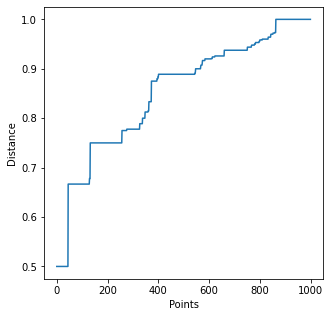

In [443]:
fig = plt.figure(figsize=(5,5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [412]:
distances

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [448]:
from multiprocessing import cpu_count, Process

In [451]:
import time

def wait_then_print(num, wait=2.0):
    '''Sleep for "wait" seconds then print the given number'''
    time.sleep(wait)
    print('Process %s done waiting!'%num)
    return

# Create a list of processes
processes = []
for i in range(4): processes.append(Process(target=wait_then_print, args=(i, 5.0)))
    
# Start each of the processes
for p in processes: p.start()
    
# Join the processes
for p in processes: p.join()

Process 0 done waiting!
Process 1 done waiting!
Process 2 done waiting!
Process 3 done waiting!
